Instalação da biblioteca AEON, que será bastante explorada nesse projeto para o carregamento dos conjuntos de dados e classificadores base (Rocket e MiniRocket).

Link do AEON com uma documentação bastante completa:
https://www.aeon-toolkit.org/en/stable/

In [1]:
!pip install aeon
!pip install "dask[dataframe]


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifierCV

from aeon.transformations.collection.convolution_based import Rocket, MiniRocket

from aeon.datasets.tsc_datasets import multivariate
from aeon.datasets import load_classification

Lista de todos os datasets multivariados que serão utilizados na avaliação experimental.

Os conjuntos de dados já estão divididos nas partições de treino/teste.

In [3]:
from aeon.datasets.tsc_datasets import multivariate

print(f'Total de {len(multivariate)} datasets')
print(f'Nomes dos datasets:')
multivariate

Total de 30 datasets
Nomes dos datasets:


['ArticularyWordRecognition',
 'AtrialFibrillation',
 'BasicMotions',
 'CharacterTrajectories',
 'Cricket',
 'DuckDuckGeese',
 'EigenWorms',
 'Epilepsy',
 'EthanolConcentration',
 'ERing',
 'FaceDetection',
 'FingerMovements',
 'HandMovementDirection',
 'Handwriting',
 'Heartbeat',
 'InsectWingbeat',
 'JapaneseVowels',
 'Libras',
 'LSST',
 'MotorImagery',
 'NATOPS',
 'PenDigits',
 'PEMS-SF',
 'PhonemeSpectra',
 'RacketSports',
 'SelfRegulationSCP1',
 'SelfRegulationSCP2',
 'SpokenArabicDigits',
 'StandWalkJump',
 'UWaveGestureLibrary']

In [4]:
# como carregar os dados de treino/teste de um conjunto de dados nas variáveis X_train, y_train
X_train, y_train = load_classification('UWaveGestureLibrary', split="Train")

# cada exemplo é multivariado, ou seja, é composto por mais de uma série temporal
# para o dataset escolhido, temos:
print(f'Quantidade de exemplos de treino: {X_train.shape[0]}')
print(f'Cada exemplo tem {X_train.shape[1]} variáveis')
print(f'Cada variável possui {X_train.shape[2]} observações')

Quantidade de exemplos de treino: 120
Cada exemplo tem 3 variáveis
Cada variável possui 315 observações


In [5]:
print(X_train.shape)
print(X_train.ndim)

(120, 3, 315)
3


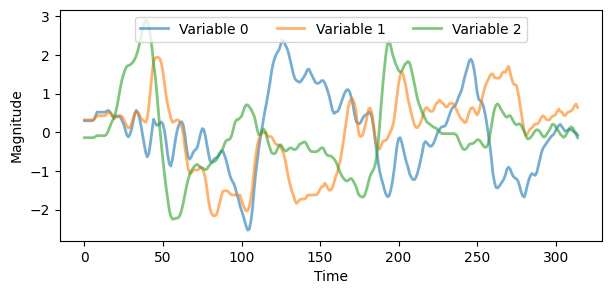

In [6]:
# vamos visualizar as séries do 15o exemplo do conjunto de treinamento
# veja como esses exemplos são acessados para entender como gerar as imagens
plt.figure(figsize=(7,3))
for dim in range(X_train.shape[1]):
  plt.plot(X_train[15][dim], linewidth=2, alpha=0.6, label=f'Variable {dim}')

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.legend(loc="upper center", ncols=3)

Vamos utilizar como algoritmo base em nossos experimentos, os classificadores **Rocke**t e **MiniRocket**

* Video explicando o funcionamento do Rocket/MiniRocket

  https://www.youtube.com/watch?v=ugx4hdytUXI

* Explicação sobre o Rocket (AEON) - Caso ainda tenham dúvidas, busquem os artigos originais: *ROCKET: exceptionally fast and accurate time series classification using random convolutional kernels* e *Minirocket: A very fast (almost) deterministic transform for time series classification*

  https://www.aeon-toolkit.org/en/stable/examples/classification/convolution_based.html

* Como usar o Rocket na biblioteca AEON:

  https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.transformations.collection.convolution_based.Rocket.html

* Como usar o MiniRocket na biblioteca AEON:

  https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.transformations.collection.convolution_based.MiniRocket.html

Vamos escolher 1 dataset específico para treinar um classificador Rocket e avaliar o seu desempenho com dados de teste

In [9]:
dataset = 'InsectWingbeat'

# carrega as partições de treino e teste
X_train, y_train = load_classification(dataset, split="Train")
X_test, y_test = load_classification(dataset, split="Test")

# instanciação do Rocket para a transformação dos dados (também vamos usar o MiniRocket, uma variação mais rápida e precisa do Rocket)
rocket = Rocket(n_kernels=10000, n_jobs=-1, random_state=6) # você pode substituir Rocket() por MiniRocket() sem alteração de parâmetros
rocket.fit(X_train)

# transformação dos dados usando Rocket
X_train2 = rocket.transform(X_train)
X_test2 = rocket.transform(X_test)

# instanciação do classificador Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

# treinamento do classificador com dados de treino
classifier.fit(X_train, y_train)

# classificação dos exemplos de teste
acc = classifier.score(X_test, y_test)

print(f'Acurácia: {acc}')


Façam um código para o treinamento/teste do classificador para cada um dos 30 datasets e ao final, salvar os resultados em um arquivo CSV com 3 colunas, sendo:

dataset, Rocket, MiniRocket


Os resultados deste arquivo serão utilizados para comparar os resultados da abordagem proposta em nosso projeto, em que usamos representações visuais dos dados

In [16]:
result = {
    "dataset": [],
    "Rocket": [],
    "MiniRocket": [],
}

fails = []

for dataset in multivariate:
    r = {
        "dataset": dataset,
        "Rocket": None,
        "MiniRocket": None,
    }
    try:
        print(dataset)
    
        # carrega as partições de treino e teste
        X_train, y_train = load_classification(dataset, split="Train")
        X_test, y_test = load_classification(dataset, split="Test")
        
        for name, Algorithm in [("Rocket", Rocket), ("MiniRocket", MiniRocket)]:
            print(name)
            
            # instanciação do Rocket para a transformação dos dados (também vamos usar o MiniRocket, uma variação mais rápida e precisa do Rocket)
            algorithm = Algorithm(num_kernels=10000, n_jobs=-1, random_state=6) # você pode substituir Rocket() por MiniRocket() sem alteração de parâmetros
            algorithm.fit(X_train)
            
            # transformação dos dados usando Rocket
            X_train = algorithm.transform(X_train)
            X_test = algorithm.transform(X_test)
            
            # instanciação do classificador Ridge
            classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
            
            # treinamento do classificador com dados de treino
            classifier.fit(X_train, y_train)
            
            # classificação dos exemplos de teste
            acc = classifier.score(X_test, y_test)
            
            print(f'Acurácia: {acc}')
            r[name] = acc
    except:
        print(f"Erro: {dataset} - {name}")
        fails.append(r)

    result["dataset"].append(r["dataset"])
    result["Rocket"].append(r["Rocket"])
    result["MiniRocket"].append(r["MiniRocket"])

    print("----------Result----------")
    print(result)


print("----------Final----------")
result

JapaneseVowels
Rocket
Acurácia: 0.8378378378378378
MiniRocket
Acurácia: 0.5459459459459459
----------Result----------
{'dataset': ['JapaneseVowels'], 'Rocket': [0.8378378378378378], 'MiniRocket': [0.5459459459459459]}
Handwriting
Rocket
Acurácia: 0.5364705882352941
MiniRocket
Acurácia: 0.15411764705882353
----------Result----------
{'dataset': ['JapaneseVowels', 'Handwriting'], 'Rocket': [0.8378378378378378, 0.5364705882352941], 'MiniRocket': [0.5459459459459459, 0.15411764705882353]}
UWaveGestureLibrary
Rocket
Acurácia: 0.915625
MiniRocket
Acurácia: 0.778125
----------Result----------
{'dataset': ['JapaneseVowels', 'Handwriting', 'UWaveGestureLibrary'], 'Rocket': [0.8378378378378378, 0.5364705882352941, 0.915625], 'MiniRocket': [0.5459459459459459, 0.15411764705882353, 0.778125]}
EigenWorms
Rocket
Acurácia: 0.8702290076335878
MiniRocket
Acurácia: 0.7480916030534351
----------Result----------
{'dataset': ['JapaneseVowels', 'Handwriting', 'UWaveGestureLibrary', 'EigenWorms'], 'Rocket': 

{'dataset': ['JapaneseVowels',
  'Handwriting',
  'UWaveGestureLibrary',
  'EigenWorms',
  'RacketSports',
  'MotorImagery',
  'SelfRegulationSCP2',
  'FingerMovements',
  'SpokenArabicDigits',
  'PenDigits',
  'ArticularyWordRecognition',
  'Cricket',
  'HandMovementDirection',
  'InsectWingbeat',
  'Libras',
  'Heartbeat',
  'ERing',
  'AtrialFibrillation',
  'EthanolConcentration',
  'CharacterTrajectories',
  'FaceDetection',
  'NATOPS',
  'PEMS-SF',
  'StandWalkJump',
  'PhonemeSpectra',
  'SelfRegulationSCP1',
  'LSST',
  'Epilepsy',
  'DuckDuckGeese',
  'BasicMotions'],
 'Rocket': [0.8378378378378378,
  0.5364705882352941,
  0.915625,
  0.8702290076335878,
  0.8947368421052632,
  0.52,
  0.5555555555555556,
  0.54,
  0.98681218735789,
  0.982275586049171,
  0.9933333333333333,
  0.9861111111111112,
  0.44594594594594594,
  None,
  0.8666666666666667,
  0.6926829268292682,
  0.9592592592592593,
  0.13333333333333333,
  0.376425855513308,
  0.9895543175487466,
  0.5729284903518729

In [17]:
print(len(result["dataset"]))
print(len(result["Rocket"]))
print(len(result["MiniRocket"]))

30
30
30


In [18]:
dt = pd.DataFrame(result)

In [20]:
dt.to_csv("C:/Users/bruno/puc/iniciacao/tests.csv")